# Prot_BERT

Paper: https://www.biorxiv.org/content/10.1101/2020.07.12.199554v3

Trained architecture: https://huggingface.co/Rostlab/prot_bert


Output:

* residue_embeddings: One vector per amino acid — useful for analyzing local structure/function.
* cls_embedding: A single vector summarizing the entire sequence — good for classification or clustering.



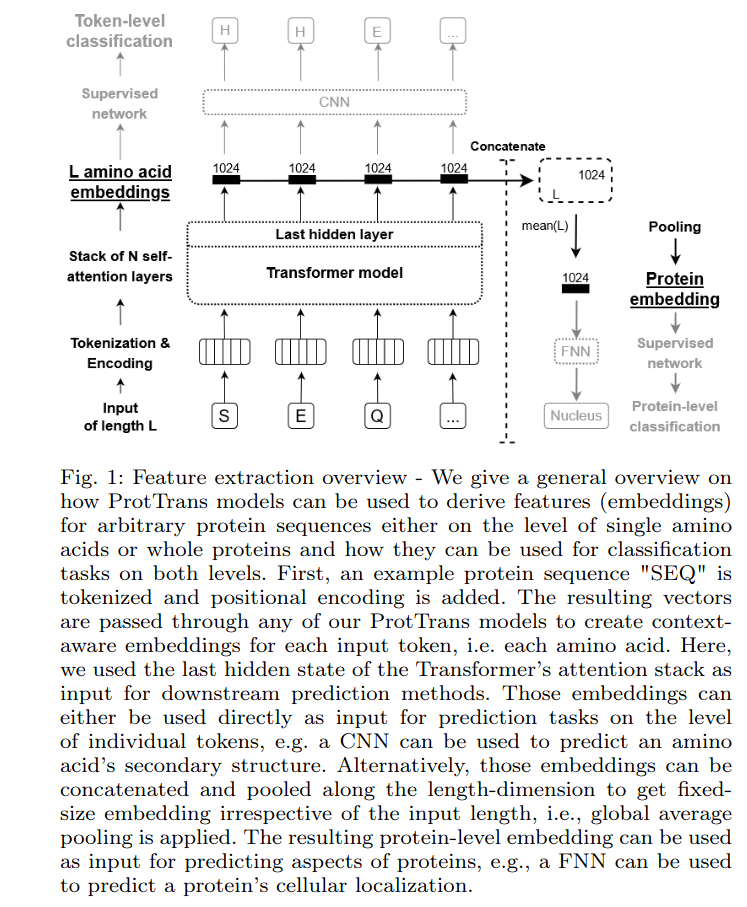

# Description

ProtBERT is a pretrained transformer model based on the [BERT](https://huggingface.co/blog/bert-101) architecture, developed to understand and analyze protein sequences. Instead of learning from natural language, it learns from millions of protein sequences, treating amino acids like words in a sentence.

> ProtBert is based on Bert model which pretrained on a large corpus of protein sequences in a **self-supervised fashion**. This means it was pretrained on the raw protein sequences only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those protein sequences.

## The usefulness

ProtBERT outputs its embeddings, i.e. a compact representation of the original protein sequence, which can then be used for further analysis.

> [...] the feature extracted from this model revealed that the LM-embeddings from unlabeled data (only protein sequences) captured important biophysical properties governing protein shape. This implied learning some of the grammar of the language of life realized in protein sequences.

## Architecture

Based on BERT-base (Bidirectional Encoder Representations from Transformers):

* 12 transformer layers
* 12 attention heads
* Hidden size: 768

Uses masked language modeling (MLM): randomly masks amino acids and predicts them, learning contextual representations.

## Training Data

* Trained on UniRef100 — a large, non-redundant database of protein sequences
* Over 2 billion amino acids from 216 million sequences
* Tokenization: amino acids are treated as individual tokens (e.g., "M K W V T F...")

## What ProtBERT Learns

* Residue-level representations: Embeddings for each amino acid that capture its biochemical context
* Sequence-level embeddings: A global summary of the entire protein (e.g., via the [CLS] token)
* Long-range dependencies: Important for capturing interactions between distant amino acids, which affect protein folding and function

## Applications

ProtBERT embeddings can be used directly or fine-tuned for downstream tasks:

* Function prediction (e.g., enzyme class, GO terms)
* Subcellular localization
* Protein–protein interaction prediction
* Mutation effect prediction
* Structure property estimation (e.g., secondary structure, solvent accessibility)

## Advantages over RNNs or CNNs

* No recurrence: Parallel computation over sequences.
* Long-range context: Self-attention models residue-residue relationships regardless of distance.
* Transfer learning: Pretrained embeddings can boost performance on small, labeled datasets.


# Setup

In [1]:
!pip install transformers biopython torch

# Example protein sequence (use FASTA format or any raw sequence)
sequence = "MKWVTFISLLFLFSSAYS"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.3 MB/s eta 0:00:00


Getting the model

In [2]:
from transformers import BertModel, BertTokenizer
import torch

# Load pretrained ProtBERT model and tokenizer from Hugging Face
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

ProtBERT expects space-separated amino acids (upper case) and special tokens.
Moreover, the [rare letters](https://en.wikipedia.org/wiki/Amino_acid#Table_of_standard_amino_acid_abbreviations_and_properties) U, Z, O, B are all clumped into X (the wildcard). We define a support function for that.

In [3]:
def preprocess_sequence(seq):
    # A regular expression would be better...
    return ' '.join(list(seq.upper())).replace('U', 'X').replace('Z', 'X').replace('O', 'X').replace('B', 'X')

Run the model, obtain the embeddings

In [4]:
# Preprocess and tokenize
seq_processed = preprocess_sequence(sequence)
tokens = tokenizer(seq_processed, return_tensors="pt")

# Disable gradient calculation since we're only doing inference,
# not training. This reduces memory usage and speeds up computation.
# Moreover, we later want to explicitly extract the embeddings, without
# the need to detach the gradient-related structure
with torch.no_grad():
  # Run through ProtBERT to get embeddings
  outputs = model(**tokens)

# Extracting the embeddings
embeddings = outputs.last_hidden_state  # shape: (1, seq_len+2, hidden_dim)

# Remove special tokens ([CLS], [SEP]) and extract residue-level embeddings
residue_embeddings = embeddings[0, 1:-1, :]  # shape: (seq_len, hidden_dim)

# You can also use the [CLS] token embedding as a sequence-level embedding
cls_embedding = embeddings[0, 0, :]  # shape: (hidden_dim,)

Take a look at the results, residue

In [5]:
# Print shape info
print("Residue embeddings shape:", residue_embeddings.shape)
# Convert to numpy for downstream ML models
residue_embeddings_np = residue_embeddings.numpy()
print(residue_embeddings_np)

Residue embeddings shape: torch.Size([18, 1024])
[[ 0.07655127  0.18962225 -0.07730474 ...  0.04535821 -0.00490018
   0.00146023]
 [-0.04754508  0.08198138  0.08094753 ...  0.09248026 -0.02194051
   0.07386144]
 [ 0.02240274  0.09696557 -0.02539053 ...  0.05697775 -0.00610091
   0.16637103]
 ...
 [ 0.05599413  0.08801784  0.05890683 ... -0.055393    0.03665066
   0.21771766]
 [ 0.02139569  0.0995248  -0.01956188 ...  0.0850208   0.04948353
   0.14955534]
 [ 0.02561058  0.06708176  0.07486121 ...  0.08783831 -0.0615745
   0.1304826 ]]


Take a look at the results, cls

In [6]:
# Print shape info
print("CLS embedding shape:", cls_embedding.shape)
# Convert to numpy for downstream ML models
cls_embedding_np = cls_embedding.numpy()
print(cls_embedding_np)

CLS embedding shape: torch.Size([1024])
[ 0.09101582  0.1242772   0.00523979 ... -0.07489944  0.00649535
  0.02439682]
